In [3]:
import os
import cv2
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder# LabelBinarizer
from multi_AdaBoost import AdaBoostClassifier as Ada

import tensorflow 
import tensorflow  as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Conv1D, MaxPooling1D

## 1) ADABOOST Neural Network

In [4]:
seed = 50
numpy.random.seed(seed)
tensorflow.random.set_seed(seed)
def train_CNN(X_train=None, y_train=None, epochs=None, batch_size=None, X_test=None, y_test=None, n_features =10, seed =100):
    ######ranome seed
    numpy.random.seed(seed)
    # set_random_seed(seed)
    tensorflow.random.set_seed(seed)
    
    model = baseline_model(n_features, seed)
    #reshape imput matrig to be compatibel to CNN
    newshape=X_train.shape
    newshape = list(newshape)
    newshape.append(1)
    newshape = tuple(newshape)
    X_train_r = numpy.reshape(X_train, newshape)#reshat the trainig data to (2300, 10, 1) for CNN
    
    lb=OneHotEncoder(sparse=False)
    y_train_b =y_train.reshape(len(y_train), 1)
    y_train_b = lb.fit_transform(y_train_b)
    #train CNN
    numpy.random.seed(seed)
    tensorflow.random.set_seed(seed)
    # set_random_seed(seed)
    model.fit(X_train_r, y_train_b, epochs=epochs, batch_size=batch_size)
    
    #####################reshap test data and evaluate:
    newshape = X_test.shape
    newshape = list(newshape)
    newshape.append(1)
    newshape = tuple(newshape)
    X_test_r = numpy.reshape(X_test, newshape)
    
    lb=OneHotEncoder(sparse=False)
    y_test_b = y_test.reshape(len(y_test),1)
    y_test_b = lb.fit_transform(y_test_b)
    
    yp=model.evaluate(X_train_r, y_train_b)
    print('\nSingle CNN evaluation on training data, [loss, test_accuracy]:')
    print(yp)

    yp=model.evaluate(X_test_r, y_test_b)
    print('\nSingle CNN evaluation on testing data, [loss, test_accuracy]:')
    print(yp)

#####deep CNN
def baseline_modelweak(n_features=10, seed=100):
    numpy.random.seed(seed)
    # set_random_seed(seed)
    tensorflow.random.set_seed(seed)
	# create model
    model = Sequential()
    model.add(Conv1D(32, 3, padding = "same", input_shape=(n_features, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))#
    model.add(Dense(n_classes))
    
    model.add(Activation('softmax'))
	# Compile model
    numpy.random.seed(seed)
    tensorflow.random.set_seed(seed)

    model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])    
    print (model.summary())
    return model

#####deep CNN
def baseline_model(n_features=10, seed=100):
    numpy.random.seed(seed)
    # set_random_seed(seed)
    tensorflow.random.set_seed(seed)
	# create model
    model = Sequential()
    model.add(Conv1D(32, 3, padding = "same", input_shape=(n_features, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))#
    model.add(Dense(n_classes))
    
    model.add(Activation('softmax'))
	# Compile model
    numpy.random.seed(seed)
    tensorflow.random.set_seed(seed)

    model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])    
    print (model.summary())
    return model

def reshape_for_CNN(X):
       ###########reshape input mak it to be compatibel to CNN
       newshape=X.shape
       newshape = list(newshape)
       newshape.append(1)
       newshape = tuple(newshape)
       X_r = numpy.reshape(X, newshape)#reshat the trainig data to (2300, 10, 1) for CNN
       return X_r

## 2) Chargement des images ( train et  test) et de  leur étiquettage (trainY0)

In [5]:
IMG_SIZE_X = 32
IMG_SIZE_Y = 32
TARGET_SIZE = (IMG_SIZE_X, IMG_SIZE_Y)
CLASSE  = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented'] 

INPUT_DIR = "Data/Alzheimer_s Dataset/"
train_path = INPUT_DIR+ 'train/'
test_path = INPUT_DIR+ '/test/'

train_batches = ImageDataGenerator(validation_split=0.1) \
                .flow_from_directory(train_path,  
                                     classes = ['NonDemented', 'VeryMildDemented', 
                                                'MildDemented', 'ModerateDemented'], target_size=TARGET_SIZE,
                                     subset='training',
                                     batch_size=10000)

validation_batches = ImageDataGenerator(validation_split=0.1) \
                     .flow_from_directory(directory=train_path, target_size=TARGET_SIZE,
                                          classes = ['NonDemented', 'VeryMildDemented', 
                                                     'MildDemented', 'ModerateDemented'], 
                                          subset='validation',
                                          batch_size=10000)
                
test_batches = ImageDataGenerator() \
                    .flow_from_directory(directory=test_path, target_size=TARGET_SIZE,
                                         classes = ['NonDemented', 'VeryMildDemented', 
                                                    'MildDemented', 'ModerateDemented'], 
                                         
                                         batch_size=10000, 
                                         shuffle=False)

trainX, trainY0  = train_batches.next()
testX, testY0  = test_batches.next()

#### STANDARISATION #####
trainX= trainX/255
testX = testX/255

#### Concatémer le multi values en  colonne  #####
s = pd.DataFrame(trainY0)
y = pd.get_dummies(s).idxmax(1)
trainY = y.to_numpy()

s = pd.DataFrame(testY0)
y = pd.get_dummies(s).idxmax(1)
testY = y.to_numpy()

#### FLATTEN #####
trainflatX = trainX.reshape(-1, trainX.shape[1]*trainX.shape[2]*trainX.shape[3])
testflatX = testX.reshape(-1, trainX.shape[1]*trainX.shape[2]*trainX.shape[3])

Found 4610 images belonging to 4 classes.
Found 511 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


## 3) Affichage 

<Figure size 576x360 with 0 Axes>

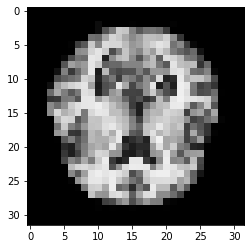

<Figure size 576x360 with 0 Axes>

In [6]:
plt.imshow(trainX[0])
plt.figure(figsize=(8,5 ))

## 3) Generation du modele (bdt_real_test_CNN)

In [ ]:
n_features=trainX.shape[1]*trainX.shape[2]*trainX.shape[3]
n_classes=4

X_train, y_train, X_test, y_test = trainflatX,trainY,testflatX,testY

batch_size=1

X_train_r = reshape_for_CNN(X_train)
X_test_r = reshape_for_CNN(X_test)

###########################################Adaboost+CNN:

from multi_adaboost_CNN import AdaBoostClassifier as Ada_CNN

n_estimators =10
epochs =1
bdt_real_test_CNN = Ada_CNN(
    base_estimator=baseline_modelweak(n_features=n_features),
    n_estimators=n_estimators,
    learning_rate=1,
    epochs=epochs)
#######discreat:

bdt_real_test_CNN.fit(X_train_r, y_train, batch_size)
test_real_errors_CNN=bdt_real_test_CNN.estimator_errors_[:]


y_pred_CNN = bdt_real_test_CNN.predict(X_train_r)
print('\n Training accuracy of bdt_real_test_CNN (AdaBoost+CNN): {}'.format(accuracy_score(bdt_real_test_CNN.predict(X_train_r),y_train)))

y_pred_CNN = bdt_real_test_CNN.predict(X_test_r)
print('\n Testing accuracy of bdt_real_test_CNN (AdaBoost+CNN): {}'.format(accuracy_score(bdt_real_test_CNN.predict(X_test_r),y_test)))

##########################################single CNN:

train_CNN(X_train = X_train, y_train = y_train, epochs=n_estimators, 
          batch_size=batch_size ,X_test = X_test, y_test = y_test, 
          n_features=n_features, seed=seed)

'''
Refrence to the original AdaBoost(__author__ = 'Xin'):
    
Multi-class AdaBoosted Decision Trees:
http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_multiclass.html
'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3072, 32)          128       
                                                                 
 activation (Activation)     (None, 3072, 32)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1536, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1536, 32)          0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 32)                1572896   
                                                        

## 4) Sauvegarde des poids en hdf5 

In [2]:
bdt_real_test_CNN.model.save_weights("model.h5")

NameError: name 'bdt_real_test_CNN' is not defined